<a href="https://colab.research.google.com/github/arefeh-rj/reasoning/blob/main/tree/main/fine%2520tuning/gemma_3_4b_it_bnb_4bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# مرحله ۱: نصب پکیج‌ها (حدود ۲-۴ دقیقه طول می‌کشه)
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps trl peft accelerate bitsandbytes xformers datasets



  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-r8pb5tpa/unsloth_2c0c6b89067a457196ea54ef55ae1df7
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-r8pb5tpa/unsloth_2c0c6b89067a457196ea54ef55ae1df7
  Resolved https://github.com/unslothai/unsloth.git to commit f3f9d148874389996636e4fd110c7255b9f62c77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 152.3 MB/s eta 0:00:00

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
test = "gsm8k_test_translated_all.xlsx"
train = "gsm8k_train_translated_all.xlsx"

# Load the latest version
test_dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "arefehrajabian/persian-gsm",
  test,

)

train_dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "arefehrajabian/persian-gsm",
  train,

)
train_dataset.head()

/tmp/ipython-input-1223728155.py:9: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  test_dataset = kagglehub.load_dataset(


100%|██████████| 298k/298k [00:00<00:00, 326kB/s]
/tmp/ipython-input-1223728155.py:16: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  train_dataset = kagglehub.load_dataset(


Using Colab cache for faster access to the 'persian-gsm' dataset.


,question,answer,translated_question,steps,translated_steps
0,Natalia sold clips to 48 of her friends in Apr...,72,ناتالیا در ماه آوریل گیره به ۴۸ نفر از دوستانش...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,ناتالیا در ماه می 48/2 = <<48/2=24>>24 گیره فر...
1,Weng earns $12 an hour for babysitting. Yester...,10,ونگ در ساعت ۱۲ دلار برای نگهداری از کودک دستمز...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,ونگ 12/60 = $<<12/60=0.2>>0.2 در هر دقیقه درآم...
2,Betty is saving money for a new wallet which c...,5,بتي در حال پس‌انداز پول برای یک کیف پول جدید ا...,"In the beginning, Betty has only 100 / 2 = $<<...",در ابتدا، بتی فقط 100 / 2 = $<<100/2=50>>50 دل...
3,"Julie is reading a 120-page book. Yesterday, s...",42,جولی در حال خواندن کتابی ۱۲۰ صفحه‌ای است. او د...,Maila read 12 x 2 = <<12*2=24>>24 pages today....,میلا امروز 12 x 2 = <<12*2=24>>24 صفحه خواند.\...
4,James writes a 3-page letter to 2 different fr...,624,جیمز هر هفته دو بار نامه‌های ۳ صفحه‌ای به ۲ دو...,He writes each friend 3*2=<<3*2=6>>6 pages a w...,او برای هر دوست ۳*۲=<<3*2=6>> ۶ صفحه در هفته م...


In [ ]:
# مرحله ۲: ایمپورت‌ها
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
from transformers import TrainingArguments

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# ۱. تنظیمات اولیه
max_seq_length = 2048
dtype = None
load_in_4bit = True

# ۲. بارگذاری مدل Gemma-3 (نسخه ۴ میلیاردی برای سرعت و دقت بالا در ریاضی عالی است)
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# ۳. اضافه کردن LoRA با پارامترهای بهینه شده برای ریاضی
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # مطابق فایل شما
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64, # بهبود: افزایش قدرت یادگیری منطق ریاضی
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)


==((====))==  Unsloth 2026.1.2: Fast Gemma3 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


model.safetensors:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [ ]:
import pandas as pd
from datasets import Dataset
from unsloth import get_chat_template

# ۱. تبدیل مستقیم دیتاست پانداز شما به فرمت مورد نیاز Unsloth
# از آنجایی که از kagglehub استفاده کردید، خروجی شما قطعا DataFrame است
hf_train_dataset = Dataset.from_pandas(train_dataset)

# ۲. تنظیم توکنایزر مخصوص Gemma-3 (تغییر حیاتی برای گوگل)
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma",
)

# ۳. تابع فرمت‌دهی با ستون‌های دقیق دیتاست شما
def formatting_prompts_func(examples):
    questions = examples["translated_question"] # سوال فارسی
    steps     = examples["translated_steps"]    # مراحل حل فارسی (Chain of Thought)
    answers   = examples["answer"]              # جواب نهایی عددی

    texts = []
    for question, step, answer in zip(questions, steps, answers):
        # ساختار پیام منطبق با استاندارد Gemma-3 برای استدلال ریاضی
        messages = [
            {
                "role": "user",
                "content": f"شما یک متخصص ریاضی هستید. سوال زیر را گام‌به‌گام حل کنید:\n\n{question}"
            },
            {
                "role": "assistant",
                "content": f"حل مرحله به مرحله:\n{step}\n\nپاسخ نهایی: {answer}"
            },
        ]
        # تولید متن نهایی برای آموزش
        text = tokenizer.apply_chat_template(messages, tokenize = False, add_generation_prompt = False)
        texts.append(text)

    return { "text" : texts }

# ۴. اجرای عملیات مپینگ و پاکسازی ستون‌های اضافی
dataset = hf_train_dataset.map(
    formatting_prompts_func,
    batched = True,
    remove_columns = hf_train_dataset.column_names # حذف ستون‌های xlsx برای جلوگیری از خطای حافظه
)

print(f"✅ تعداد {len(dataset)} نمونه آماده آموزش شدند.")
print("نمونه متن تولید شده برای مدل:")
print(dataset[0]["text"])

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

✅ تعداد 7473 نمونه آماده آموزش شدند.
نمونه متن تولید شده برای مدل:
<bos><start_of_turn>user
شما یک متخصص ریاضی هستید. سوال زیر را گام‌به‌گام حل کنید:

ناتالیا در ماه آوریل گیره به ۴۸ نفر از دوستانش فروخت و سپس در ماه می نصف این تعداد گیره فروخت. در مجموع ناتالیا در ماه آوریل و می چند گیره فروخت؟<end_of_turn>
<start_of_turn>model
حل مرحله به مرحله:
ناتالیا در ماه می 48/2 = <<48/2=24>>24 گیره فروخت.
ناتالیا در مجموع در ماه آوریل و می 48+24 = <<48+24=72>>72 گیره فروخت.
#### 72

پاسخ نهایی: 72<end_of_turn>



In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

# ۱. غیرفعال کردن سرویس‌های اضافه برای جلوگیری از خطا
os.environ["WANDB_DISABLED"] = "true"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        max_steps = 120,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        # اضافه کردن این دو خط برای حل مشکل شما:
        report_to = "none", # جلوگیری از خطای wandb
        logging_dir = "logs", # ذخیره لاگ‌ها به صورت محلی
    ),
)



Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1 | Total steps = 120
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 65,576,960 of 4,365,656,432 (1.50% trained)


Step,Training Loss
1,2.251900
2,2.357400
3,2.621200
4,2.482000
5,2.236900
6,2.004500
7,1.914400
8,1.680000
9,1.777500
10,1.674300


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


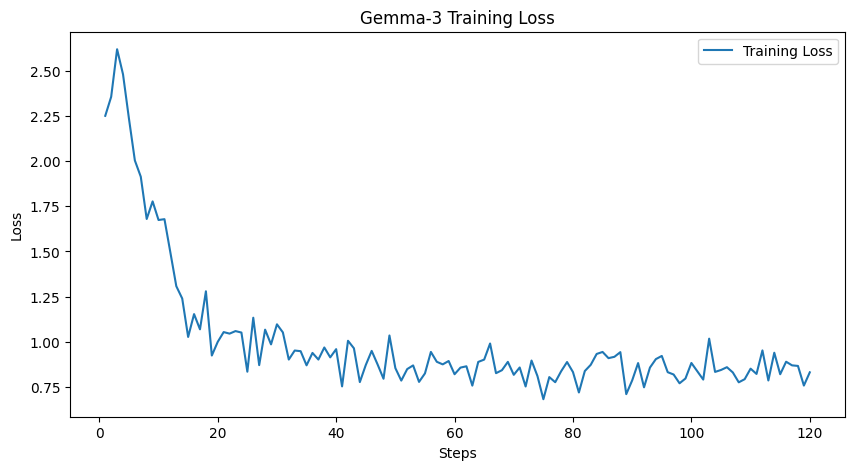

In [ ]:
import matplotlib.pyplot as plt

# دریافت آمارهای آموزش از متغیر trainer_stats که قبلا تعریف کردید
history = trainer_stats.metrics
# یا اگر از متغیر trainer استفاده می‌کنید:
# history = trainer.state.log_history

steps = [x['step'] for x in trainer.state.log_history if 'loss' in x]
loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(steps, loss, label='Training Loss')
plt.title('Gemma-3 Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# ۱. ذخیره با اسم دلخواه
custom_name = "gemma-3-4b-it-gsm8k-persian"

model.save_pretrained(custom_name)
tokenizer.save_pretrained(custom_name)

# ۲. زیپ کردن همان پوشه برای دانلود
import shutil
shutil.make_archive(custom_name, 'zip', custom_name)

# ۳. دانلود
from google.colab import files
files.download(f"{custom_name}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# این کد مدل اصلی را با تغییرات شما ترکیب کرده و در یک پوشه جدید ذخیره می‌کند
model.save_pretrained_merged(
    "gemma_math_final_merged", # نام پوشه نهایی
    tokenizer,
    save_method = "merged_16bit", # روش ادغام (دقت بالا)
)

# زیپ کردن برای دانلود (حجم این فایل چند گیگابایت خواهد بود)
import shutil
shutil.make_archive("gemma_math_final_merged", 'zip', "gemma_math_final_merged")

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# کپی کردن پوشه مدل به درایو (نام پوشه خودتان را جایگزین کنید)
import shutil
shutil.copytree("/content/gemma_math_final_merged", "/content/drive/MyDrive/gemma_math_final_merged")
print("✅ مدل با موفقیت در گوگل درایو کپی شد")

Mounted at /content/drive
✅ مدل با موفقیت در گوگل درایو کپی شد


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# کپی کردن پوشه مدل به درایو (نام پوشه خودتان را جایگزین کنید)
import shutil
shutil.copytree("/content/gemma_math_final_merged", "/content/drive/MyDrive/gemma_math_final_merged2")
print("✅ مدل با موفقیت در گوگل درایو کپی شد")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ مدل با موفقیت در گوگل درایو کپی شد


In [ ]:
!rsync -ah --progress /content/gemma_math_final_merged/model-00001-of-00002.safetensors/ /content/drive/MyDrive/gemma_math_final_merged/

sending incremental file list
created directory /content/drive/MyDrive/gemma_math_final_merged3
./
added_tokens.json
             35 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=21/23)
chat_template.jinja
            638 100%  623.05kB/s    0:00:00 (xfr#2, to-chk=20/23)
config.json
          3.13K 100%    2.98MB/s    0:00:00 (xfr#3, to-chk=19/23)
model-00001-of-00002.safetensors
          4.96G 100%  356.58MB/s    0:00:13 (xfr#4, to-chk=18/23)
model-00002-of-00002.safetensors
          3.64G 100%  374.41MB/s    0:00:09 (xfr#5, to-chk=17/23)
model.safetensors.index.json
         90.56K 100%  419.13kB/s    0:00:00 (xfr#6, to-chk=16/23)
preprocessor_config.json
            570 100%    2.64kB/s    0:00:00 (xfr#7, to-chk=15/23)
processor_config.json
              0 100%    0.00kB/s    0:00:00 (xfr#8, to-chk=14/23)
special_tokens_map.json
            670 100%    3.10kB/s    0:00:00 (xfr#9, to-chk=13/23)
tokenizer.json
         33.38M 100%   54.42MB/s    0:00:00 (xfr#10, to-chk=12/23)
tokenizer

In [ ]:
from unsloth import FastLanguageModel
import pandas as pd
import torch

# ۱. آماده‌سازی مدل برای حالت استنتاج
FastLanguageModel.for_inference(model)

# ۲. انتخاب ۱۰ سطر اول (مطمئن می‌شویم از دیتاست اصلی استفاده می‌کنیم)
# اگر test_dataset یک دیتافریم پانداز است:
test_samples = test_dataset.head(10)

print("--- در حال تولید پاسخ‌ها ---")

results = []

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])

    # اصلاح ساختار Content برای جلوگیری از خطای TypeError
    # در Gemma-3، محتوا باید لیستی از دیکشنری‌ها باشد تا بخش مالتی‌مودال خطا ندهد
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"شما یک متخصص ریاضی هستید. سوال زیر را گام‌به‌گام حل کنید:\n\n{question}"}
            ]
        }
    ]

    # حالا دستور apply_chat_template بدون خطا اجرا می‌شود
    inputs = tokenizer.apply_chat_template(
        prompt,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt",
    ).to("cuda")

    # ادامه کد تولید پاسخ...
    with torch.no_grad():
        outputs = model.generate(
            input_ids = inputs,
            max_new_tokens = 512,
            temperature = 0.1,
            top_p = 0.9,
            use_cache = True,
        )

    generated_tokens = outputs[0][inputs.shape[1]:]
    response = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    print(f"\n📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 پاسخ مدل:\n{response}")
    print("-" * 50)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--- در حال تولید پاسخ‌ها ---

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 پاسخ مدل:
حل مرحله به مرحله:
او هر روز 16 تخم می‌گذارد، اما 3 تخم می‌خورد و 4 تخم را برای پختن مافین استفاده می‌کند، بنابراین او 16 - 3 - 4 = <<16-3-4=9>> 9 تخم باقی می‌گذارد.
او 9 تخم را به قیمت 2 دلار برای هر تخم مرغ تازه در بازار کشاورزان می‌فروشد، بنابراین او 9 * 2 = <<9*2=18>> 18 دلار در روز به دست می‌آورد.
#### 18

پاسخ نهایی: 18
--------------------------------------------------

📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 پاسخ مدل:
حل مرحله به مرحله:
ردای عبا به 2 گُل آبی و 2 گُل سفید نیاز دارد.
بنابراین، 2 + 2 = <<2+2=4>> 4 گُل الیاف لازم است.
#### 4

پاسخ نه

In [ ]:
import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
        {
            "role": "user",
            "content": [{"type": "text", "text": f"شما یک متخصص ریاضی هستید. سوال زیر را گام‌به‌گام حل کنید و در انتها فقط عدد نهایی را بنویسید:\n\n{question}"}]
        }
    ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=512,
            temperature=0.1,
            use_cache=True
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_Results_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
حل مرحله به مرحله:
او هر روز 16 تخم می‌گذارد، 3 تخم می‌خورد و 4 تخم را برای پختن مافین استفاده می‌کند، بنابراین او 16 - 3 - 4 = <<16-3-4=9>> 9 تخم باقی می‌گذارد.
او 9 تخم را به قیمت 2 دلار برای هر تخم مرغ تازه در بازار کشاورزان می‌فروشد، بنابراین او 9 * 2 = <<9*2=18>> 18 دلار در بازار کشاورزان به دست می‌آورد.
#### 18

پاسخ نهایی: 18
🔢 عدد استخراج شده: 18.0 | جواب واقعی: 18.0
📊 وضعیت: ✅ درست
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
حل مرحله به مرحله:
ردای عبا به 2 گُل آبی و 2 گُل سفید نیاز

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
        {
            "role": "user",
            "content": [{"type": "text", "text": f"Solve the following math problem step-by-step in Persian. Explain your reasoning clearly and provide the final numerical answer at the end:\n\n{question}"}]
        }
    ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=512,
            temperature=0.1,
            use_cache=True
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_ResultsenglishPrompt_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
حل مرحله به مرحله:
او هر روز 16 تخم می‌گذارد، اما 3 تخم می‌خورد و 4 تخم را برای پختن مافین استفاده می‌کند.
بنابراین، او 16 - 3 - 4 = <<16-3-4=9>> 9 تخم باقی می‌گذارد.
او 9 تخم را به قیمت 2 دلار برای هر تخم مرغ تازه در بازار کشاورزان می‌فروشد.
بنابراین، او 9 * 2 = <<9*2=18>> 18 دلار در بازار کشاورزان به دست می‌آورد.
#### 18

پاسخ نهایی: 18
🔢 عدد استخراج شده: 18.0 | جواب واقعی: 18.0
📊 وضعیت: ✅ درست
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
حل مرحله به مرحله:
یک ردای عبا به ۲ گُل آبی و نصف آن

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# این کد لایه‌های آموزش دیده (LoRA) را لیست می‌کند
for name, param in model.named_parameters():
    if "lora" in name:
        print(f"✅ LoRA Layer found: {name}")

✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.1.self_attn.k_proj.lora_A.default.weight
✅ LoRA Layer found: base_model.model.model.vision_tower.vision_model.encoder.layers.1.self_attn.k_proj.lora_B.default.weight


In [ ]:


import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
          {
              "role": "user",
              "content": [
                  {
                      "type": "text",
                      "text": f"Role: You are an award-winning Mathematics Professor. Solve this problem with extreme precision.\nInstruction: حل گام‌به‌گام به فارسی همراه با منطق ریاضی و اعلام عدد نهایی در انتها.\nQuestion: {question}"
                  }
              ]
          }
      ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=512,
            temperature=0.1,
            use_cache=True
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_ResultsenglishPrompt_systemRole_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
حل مرحله به مرحله:
او هر روز 16 تخم می‌گذارد و 3 تخم می‌خورد، بنابراین 16 - 3 = <<16-3=13>> 13 تخم باقی می‌ماند.
او هر روز 4 تخم برای پختن مافین استفاده می‌کند، بنابراین 13 - 4 = <<13-4=9>> 9 تخم باقی می‌ماند.
او هر روز 9 تخم را به قیمت 2 دلار برای هر تخم مرغ تازه در بازار کشاورزان می‌فروشد، بنابراین 9 * 2 = $<<9*2=18>> 18 دلار در روز به دست می‌آورد.
#### 18

پاسخ نهایی: 18
🔢 عدد استخراج شده: 18.0 | جواب واقعی: 18.0
📊 وضعیت: ✅ درست
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
حل مرحله به مرحل

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a professional mathematician. Always solve problems step-by-step in Persian and provide the final answer as a single number at the end."}]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": f"Question: {question}"}]
        }
    ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=512,
            temperature=0.1,
            use_cache=True
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_Results_englishPrompt_REALsystemRole_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
او هر روز ۱۶ تخم می‌گذارد، اما ۳ تخم می‌خورد و ۴ تخم را برای پختن مافین استفاده می‌کند. بنابراین، او ۱۶ - ۳ - ۴ = <<16-3-4=9>> ۹ تخم باقی می‌گذارد. او هر تخم را به قیمت ۲ دلار می‌فروشد، بنابراین او ۹ * ۲ = <<9*2=18>> ۱۸ دلار در بازار کشاورزان به دست می‌آورد.
#### ۱۸

Final Answer: 18
🔢 عدد استخراج شده: 18.0 | جواب واقعی: 18.0
📊 وضعیت: ✅ درست
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
یک ردای عبا به ۲ گُل آبی و نصف آن گُل سفید نیاز دارد.
بنابراین، تعداد گُل‌های آبی برابر است با ۲ گُل.
تعداد 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a professional mathematician. Always solve problems step-by-step in Persian and provide the final answer as a single number at the end."}]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": f" سوال زیر را گام‌به‌گام حل کنید و در انتها فقط عدد نهایی را بنویسید:\n\n{question}"}]
        }
    ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=512,
            temperature=0.1,
            use_cache=True
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_Results_differentPrompt_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
حل مرحله به مرحله:
او هر روز 16 تخم می‌گذارد، پس 16 - 3 - 4 = <<16-3-4=9>> 9 تخم باقی می‌ماند.
او هر تخم را به قیمت 2 دلار می‌فروشد، پس 9 تخم * 2 دلار/تخم = <<9*2=18>> 18 دلار به دست می‌آورد.
#### 18

پاسخ نهایی: 18
🔢 عدد استخراج شده: 18.0 | جواب واقعی: 18.0
📊 وضعیت: ✅ درست
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
حل مرحله به مرحله:
ردای عبا به 2 گُل آبی و 1 گُل سفید نیاز دارد.
بنابراین، 2+1=<<2+1=3>>3 گُل الیاف لازم است.
#### 3

پاسخ نهایی: 3
🔢 عدد استخراج شده: 3.0 | جواب واقعی: 3.0
📊 وض

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a professional mathematician. Always solve problems step-by-step in Persian and provide the final answer as a single number at the end."}]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": f" سوال زیر را گام‌به‌گام حل کنید و در انتها فقط عدد نهایی را بنویسید:\n\n{question}"}]
        }
    ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids = inputs,
            max_new_tokens = 512,
            temperature = 0.2,    # نه صفر که قفل شود، نه یک که هذیان بگوید
            do_sample = True,     # اجازه به تغییرات جزئی
            top_p = 0.9,          # محدود کردن انتخاب‌ها به گزینه‌های معقول
            repetition_penalty = 1.0, # مدل را مجبور می‌کند تکراری ننویسد
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_Results_change inputs_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
او ۱۵۶ تخم می‌گذارد، زیرا ۱۲+۴=۱۶*۲۴ = ۱۵۶
او هر روز ۸ دلار دریافت می‌کند که از آن ۴ دلار صرف غذا شد (۳+۲) می‌شود 16/4 = $<<8>>8
#### 8

پاسخ نهایی: <<8>>8
🔢 عدد استخراج شده: 8.0 | جواب واقعی: 18.0
📊 وضعیت: ❌ غلط
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
حل مرحله به مرحله:
ردایی از ردای عبا، دو گل آبی به خاطر وجود دو گل داشته است که هر کدام ۶ گل به صورت ردیفی دارند و هر یک ۲۰ گل دارند، در نتیجه دو گل آبی برای ردای عبا دو برابر می‌شود زیرا ۶ × ۸ = <<6*8=48>> ۴۸. این مقدار باید تقسیم بر دو ش

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


import pandas as pd
import torch
import re
from unsloth import FastLanguageModel
from google.colab import files

# ۱. تابع هوشمند برای استخراج عدد نهایی
def extract_number(text):
    text = str(text).replace(',', '') # حذف کاما برای اعدادی مثل 1,200
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return float(numbers[-1]) if numbers else None

# ۲. آماده‌سازی برای استنتاج
FastLanguageModel.for_inference(model)

test_samples = test_dataset.head(10)
results_for_excel = []
correct_predictions = 0

print(f"🚀 شروع پردازش {len(test_samples)} نمونه تست...\n")
print("="*50)

for index, row in test_samples.iterrows():
    question = str(row["translated_question"])
    actual_answer_text = str(row["answer"])
    true_val = extract_number(actual_answer_text)

    # فرمت پیام سازگار با Gemma-3
    prompt = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a professional mathematician. Always solve problems step-by-step in Persian and provide the final answer as a single number at the end."}]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": f" سوال زیر را گام‌به‌گام حل کنید و در انتها فقط عدد نهایی را بنویسید:\n\n{question}"}]
        }
    ]

    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    # تولید پاسخ توسط مدل
    with torch.no_grad():
        outputs = model.generate(
            input_ids = inputs,
            max_new_tokens = 512,
            temperature = 0.2,    # نه صفر که قفل شود، نه یک که هذیان بگوید
            do_sample = True,     # اجازه به تغییرات جزئی
            top_p = 0.9,          # محدود کردن انتخاب‌ها به گزینه‌های معقول
            repetition_penalty = 1.0, # مدل را مجبور می‌کند تکراری ننویسد
        )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    model_val = extract_number(response)

    # بررسی صحت پاسخ
    is_correct = False
    if model_val is not None and true_val is not None:
        if abs(model_val - true_val) < 1e-5:
            correct_predictions += 1
            is_correct = True

    # --- پرینت در کنسول برای مشاهده Process ---
    status_icon = "✅ درست" if is_correct else "❌ غلط"
    print(f"📍 نمونه {index + 1}:")
    print(f"❓ سوال: {question}")
    print(f"🤖 استدلال مدل:\n{response}")
    print(f"🔢 عدد استخراج شده: {model_val} | جواب واقعی: {true_val}")
    print(f"📊 وضعیت: {status_icon}")
    print("-" * 50)

    # ذخیره برای اکسل
    results_for_excel.append({
        "ID": index + 1,
        "سوال": question,
        "پاسخ کامل مدل": response,
        "عدد مدل": model_val,
        "عدد واقعی": true_val,
        "نتیجه": status_icon
    })

# ۳. محاسبات نهایی و خروجی
accuracy = (correct_predictions / len(test_samples)) * 100
df_output = pd.DataFrame(results_for_excel)
file_name = f"Gemma3_Math_Results_change inputs_Acc_{accuracy}.xlsx"
df_output.to_excel(file_name, index=False)

print(f"\n🎯 ارزیابی تمام شد!")
print(f"📈 دقت کل (Total Accuracy): {accuracy}%")

# دانلود فایل
files.download(file_name)

🚀 شروع پردازش 10 نمونه تست...

📍 نمونه 1:
❓ سوال: مرغ‌های جانت هر روز ۱۶ تخم می‌گذارند. او هر صبح سه تخم برای صبحانه می‌خورد و هر روز چهار تخم را برای پختن مافین برای دوستانش استفاده می‌کند. او باقی‌مانده تخم‌ها را به قیمت ۲ دلار برای هر تخم مرغ تازه در بازار کشاورزان به صورت روزانه می‌فروشد. او هر روز چقدر دلار در بازار کشاورزان به دست می‌آورد؟
🤖 استدلال مدل:
حل مرحله به مرحله:
او هر روز 16 تخم می‌گذارد، اما 3 تخم می‌خورد و 4 تخم را برای پختن مافین استفاده می‌کند.
بنابراین، او 16 - 3 - 4 = <<16-3-4=9>> 9 تخم باقی می‌گذارد.
او هر تخم را به قیمت 2 دلار می‌فروشد، بنابراین او 9 * 2 = <<9*2=18>> 18 دلار به دست می‌آورد.
#### 18

پاسخ نهایی: 18
🔢 عدد استخراج شده: 18.0 | جواب واقعی: 18.0
📊 وضعیت: ✅ درست
--------------------------------------------------
📍 نمونه 2:
❓ سوال: یک ردای عبا ۲ گُل (بُلت) الیاف آبی و نصف آن الیاف سفید نیاز دارد. در مجموع چند گُل الیاف لازم است؟

🤖 استدلال مدل:
حل مرحله به مرحله:
ردای عبا به 2 گُل آبی و 1 گُل سفید نیاز دارد.
بنابراین، 2+1=<<2+1=3>>3 گُل الیاف لازم است.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>